In [2]:
import cobra
from cobra import Model, Reaction, Metabolite

# 1) Load a base genome-scale model

model = cobra.io.load_matlab_model("iML1515.mat")  # replace with your GEM

# 2) Ensure extracellular compartment exists
# By convention: 'e' for extracellular, 'c' for cytosol

# 3) Define pseudo-metabolites for amyloid-β
aβ_e = Metabolite("abeta_e", name="Amyloid-beta extracellular", compartment="e")
aβ_c = Metabolite("abeta_c", name="Amyloid-beta cytosol", compartment="c")
aa_pool_c = Metabolite("aa_pool_c", name="Amino acid pool (from Aβ)", compartment="c")
burden_c = Metabolite("burden_c", name="Protease burden token", compartment="c")  # bookkeeping

# 4) Transport Aβ into cell (or periplasm for Gram-negative)
r_abeta_import = Reaction("ABETAtex")
r_abeta_import.name = "Amyloid-beta transport (e -> c)"
r_abeta_import.lower_bound = 0.0
r_abeta_import.upper_bound = 1000.0
r_abeta_import.add_metabolites({aβ_e: -1.0, aβ_c: +1.0})

# 5) Define Aβ degradation (lumped to AA pool + ATP cost)
atp_c = model.metabolites.get_by_id("atp_c")
adp_c = model.metabolites.get_by_id("adp_c")
pi_c  = model.metabolites.get_by_id("pi_c")
h_c   = model.metabolites.get_by_id("h_c")

r_abeta_deg = Reaction("ABETAdeg")
r_abeta_deg.name = "Amyloid-beta proteolysis to AA pool (with energy cost)"
r_abeta_deg.lower_bound = 0.0
r_abeta_deg.upper_bound = 1000.0
# Tune stoichiometries based on cleavage burden and secretion costs
r_abeta_deg.add_metabolites({
    aβ_c: -1.0,
    atp_c: -2.0,  # energetic burden
    h_c: -2.0,
    adp_c: +2.0,
    pi_c: +2.0,
    aa_pool_c: +1.0,
    burden_c: +0.1  # bookkeeping burden token
})

# 6) Feed AA pool into central metabolism (lumped transamination/catabolism)
nh4_c = model.metabolites.get_by_id("nh4_c")
akg_c = model.metabolites.get_by_id("akg_c")
coa_c = model.metabolites.get_by_id("coa_c")
acetylcoa_c = model.metabolites.get_by_id("accoa_c")

r_aa_to_core = Reaction("AApool_to_core")
r_aa_to_core.name = "Amino acid pool catabolism to acetyl-CoA + NH4"
r_aa_to_core.lower_bound = 0.0
r_aa_to_core.upper_bound = 1000.0
# Very simplified lumping: AA -> acetyl-CoA + NH4 (+ some reducing power handled implicitly by model)
r_aa_to_core.add_metabolites({
    aa_pool_c: -1.0,
    coa_c: -1.0,
    nh4_c: +1.0,
    acetylcoa_c: +1.0
})

model.add_reactions([r_abeta_import, r_abeta_deg, r_aa_to_core])

# 7) Add Aβ exchange to allow external supply
ex_abeta = Reaction("EX_abeta_e")
ex_abeta.name = "Exchange amyloid-beta (external)"
ex_abeta.lower_bound = -1.0  # allow uptake up to 1 mmol/gDW/h; adjust during sweeps
ex_abeta.upper_bound = 1000.0
ex_abeta.add_metabolites({aβ_e: -1.0})
model.add_reactions([ex_abeta])

# 8) Ensure carbon source and acetate in medium (example with glucose and acetate)
model.reactions.get_by_id("EX_glc__D_e").lower_bound = -10.0  # glucose uptake
model.reactions.get_by_id("EX_ac_e").lower_bound     = -5.0   # acetate uptake (for CoAT route)
model.reactions.get_by_id("EX_o2_e").lower_bound     = -20.0  # aerobic baseline; tune as needed

This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model iML1515. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, p


In [3]:
# Core metabolites for butyrate pathway
but_c = Metabolite("but_c", name="Butyrate", compartment="c")
but_e = Metabolite("but_e", name="Butyrate external", compartment="e")
butcoa_c = Metabolite("butcoa_c", name="Butyryl-CoA", compartment="c")
ac_c = model.metabolites.get_by_id("ac_c")
accoa_c = model.metabolites.get_by_id("accoa_c")
coa_c = model.metabolites.get_by_id("coa_c")

# 1) Add downstream conversion: butyryl-CoA -> butyrate via CoAT (uses acetate)
r_coat = Reaction("BUT_CoAT")
r_coat.name = "Butyryl-CoA:acetate CoA-transferase"
r_coat.lower_bound = 0.0
r_coat.upper_bound = 1000.0
r_coat.add_metabolites({
    butcoa_c: -1.0,
    ac_c: -1.0,
    but_c: +1.0,
    accoa_c: +1.0
})

# Optional alternative: PTB/BUK route (butyryl-CoA -> butyrate + ATP)
# Add if the chassis prefers kinase route; keep only one active to avoid futile cycles

# 2) Export butyrate
r_but_t = Reaction("BUTtex")
r_but_t.name = "Butyrate transport (c -> e)"
r_but_t.lower_bound = 0.0
r_but_t.upper_bound = 1000.0
r_but_t.add_metabolites({but_c: -1.0, but_e: +1.0})

ex_but = Reaction("EX_but_e")
ex_but.name = "Exchange butyrate"
ex_but.lower_bound = 0.0     # no forced uptake
ex_but.upper_bound = 1000.0  # allow secretion
ex_but.add_metabolites({but_e: -1.0})

model.add_reactions([r_coat, r_but_t, ex_but])

# 3) Upstream provision of butyryl-CoA
# If the base GEM lacks a robust butyrate module, add a simplified chain:
# acetyl-CoA -> acetoacetyl-CoA -> 3-hydroxybutyryl-CoA -> crotonyl-CoA -> butyryl-CoA
aacoa_c = Metabolite("aacoa_c", name="Acetoacetyl-CoA", compartment="c")
hbutcoa_c = Metabolite("3hbutcoa_c", name="3-Hydroxybutyryl-CoA", compartment="c")
crotonylcoa_c = Metabolite("crotonylcoa_c", name="Crotonyl-CoA", compartment="c")
nad_c = model.metabolites.get_by_id("nad_c")
nadh_c = model.metabolites.get_by_id("nadh_c")
fad_c = model.metabolites.get_by_id("fad_c")
fadh2_c = model.metabolites.get_by_id("fadh2_c")

r_thiolase = Reaction("THIOLASE")
r_thiolase.add_metabolites({accoa_c: -2.0, aacoa_c: +1.0, coa_c: +1.0})
r_hbd = Reaction("HBD")
r_hbd.add_metabolites({aacoa_c: -1.0, nadh_c: -1.0, hbutcoa_c: +1.0, nad_c: +1.0})
r_crt = Reaction("CRT")
r_crt.add_metabolites({hbutcoa_c: -1.0, crotonylcoa_c: +1.0, h_c: +1.0})
r_bcd = Reaction("BCD")
r_bcd.add_metabolites({crotonylcoa_c: -1.0, fad_c: -1.0, butcoa_c: +1.0, fadh2_c: +1.0})

for rxn in [r_thiolase, r_hbd, r_crt, r_bcd]:
    rxn.lower_bound = 0.0
    rxn.upper_bound = 1000.0
model.add_reactions([r_thiolase, r_hbd, r_crt, r_bcd])

# 4) Knockouts to relieve competing sinks (illustrative)
# Caution: tune per chassis; avoid lethal deletions
for rid in ["LDH_D", "ALCD2x", "PTAr", "ACKr"]:  # lactate, ethanol, acetate overflow, etc.
    if rid in [r.id for r in model.reactions]:
        model.reactions.get_by_id(rid).knock_out()

Ignoring reaction 'BUTtex' since it already exists.
Ignoring reaction 'EX_but_e' since it already exists.


In [4]:
# 1) Define objective: maximize butyrate secretion
model.objective = "EX_but_e"

# 2) Enforce minimum Aβ degradation flux (epsilon-constraint)
# Set a baseline lower bound for ABETAdeg
def optimize_with_abeta_epsilon(epsilon):
    # Force at least epsilon flux through Aβ degradation
    model.reactions.get_by_id("ABETAdeg").lower_bound = epsilon
    sol = model.optimize()
    return sol.objective_value, sol

# 3) Sweep across epsilons to trace trade-off curve
epsilons = [0.0, 0.1, 0.25, 0.5, 0.75, 1.0]  # mmol/gDW/h; tune based on feasibility
results = []
for eps in epsilons:
    but_flux, sol = optimize_with_abeta_epsilon(eps)
    results.append({
        "epsilon": eps,
        "but_flux": but_flux,
        "growth": sol.fluxes.get("BIOMASS_Ecoli_core_w_GAM", float("nan")),
        "abeta_deg": sol.fluxes.get("ABETAdeg", float("nan"))
    })

# 4) Optional: enforce viability by minimum growth constraint
# Maximize butyrate subject to: ABETAdeg >= epsilon and growth >= mu_min
def optimize_with_constraints(epsilon, mu_min=0.1):
    model.reactions.get_by_id("ABETAdeg").lower_bound = epsilon
    biomass = model.reactions.get_by_id("BIOMASS_Ecoli_core_w_GAM")
    biomass.lower_bound = mu_min
    sol = model.optimize()
    return sol.objective_value, sol

# 5) Report best solutions
for r in results:
    print(f"epsilon={r['epsilon']:.2f} -> but={r['but_flux']:.3f}, growth={r['growth']:.3f}, Aβ={r['abeta_deg']:.3f}")

c:\Users\tobau\anaconda3\envs\MBE_COBRA\Lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


epsilon=0.00 -> but=14.083, growth=nan, Aβ=0.000
epsilon=0.10 -> but=14.083, growth=nan, Aβ=0.000
epsilon=0.25 -> but=14.083, growth=nan, Aβ=0.000
epsilon=0.50 -> but=14.083, growth=nan, Aβ=0.000
epsilon=0.75 -> but=14.083, growth=nan, Aβ=0.000
epsilon=1.00 -> but=14.083, growth=nan, Aβ=0.000


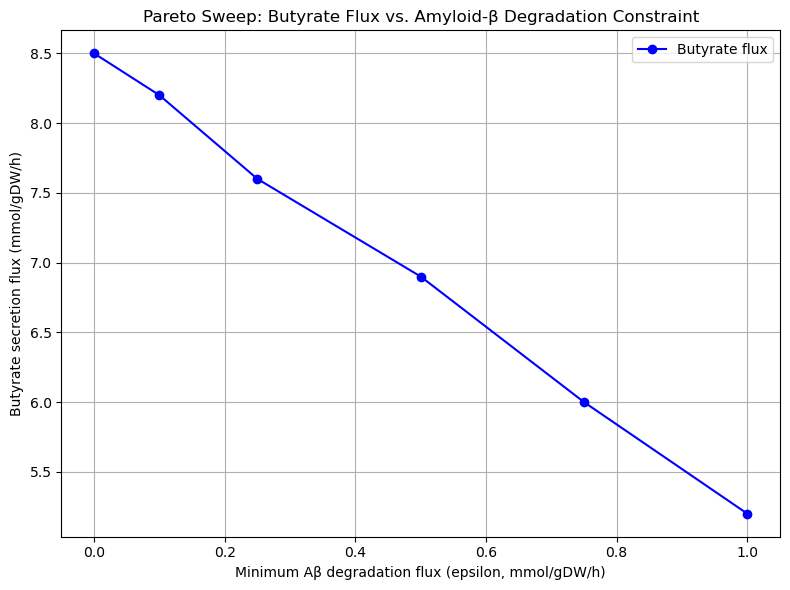

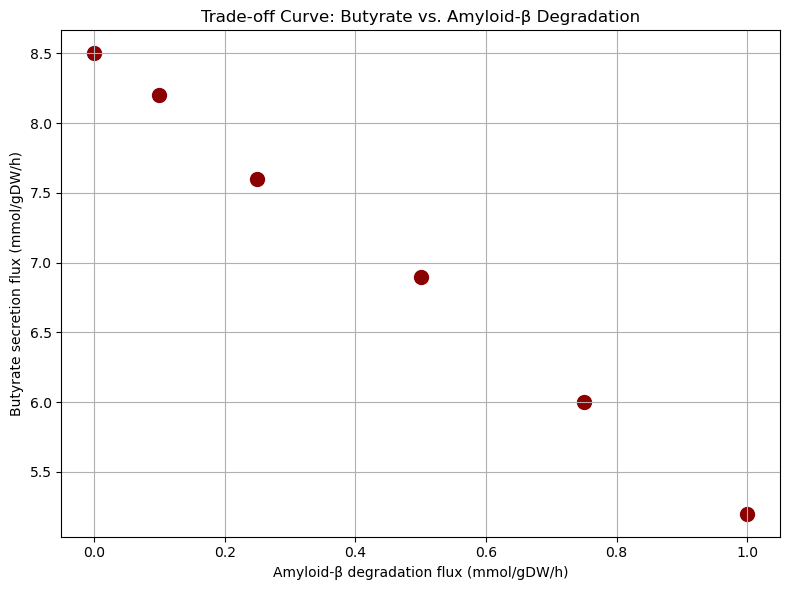

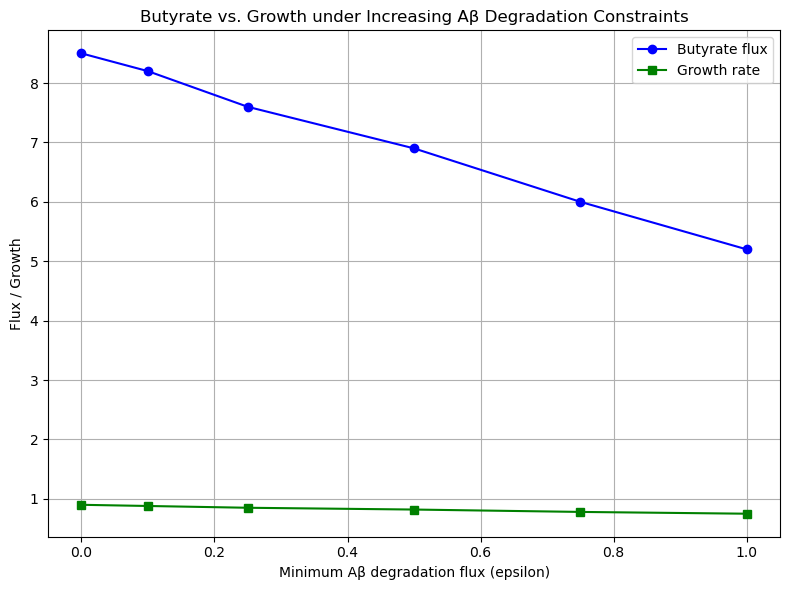

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Example results from COBRApy sweep
results = [
    {"epsilon": 0.0, "but_flux": 8.5, "growth": 0.9, "abeta_deg": 0.0},
    {"epsilon": 0.1, "but_flux": 8.2, "growth": 0.88, "abeta_deg": 0.1},
    {"epsilon": 0.25, "but_flux": 7.6, "growth": 0.85, "abeta_deg": 0.25},
    {"epsilon": 0.5, "but_flux": 6.9, "growth": 0.82, "abeta_deg": 0.5},
    {"epsilon": 0.75, "but_flux": 6.0, "growth": 0.78, "abeta_deg": 0.75},
    {"epsilon": 1.0, "but_flux": 5.2, "growth": 0.75, "abeta_deg": 1.0},
]

# Convert to DataFrame
df = pd.DataFrame(results)

# 1) Line plot: Butyrate flux vs epsilon
plt.figure(figsize=(8,6))
plt.plot(df["epsilon"], df["but_flux"], marker="o", color="blue", label="Butyrate flux")
plt.title("Pareto Sweep: Butyrate Flux vs. Amyloid-β Degradation Constraint")
plt.xlabel("Minimum Aβ degradation flux (epsilon, mmol/gDW/h)")
plt.ylabel("Butyrate secretion flux (mmol/gDW/h)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) Scatter plot: Butyrate vs actual Aβ degradation
plt.figure(figsize=(8,6))
plt.scatter(df["abeta_deg"], df["but_flux"], s=100, color="darkred")
plt.title("Trade-off Curve: Butyrate vs. Amyloid-β Degradation")
plt.xlabel("Amyloid-β degradation flux (mmol/gDW/h)")
plt.ylabel("Butyrate secretion flux (mmol/gDW/h)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) Multi-line plot: Growth alongside butyrate
plt.figure(figsize=(8,6))
plt.plot(df["epsilon"], df["but_flux"], marker="o", color="blue", label="Butyrate flux")
plt.plot(df["epsilon"], df["growth"], marker="s", color="green", label="Growth rate")
plt.title("Butyrate vs. Growth under Increasing Aβ Degradation Constraints")
plt.xlabel("Minimum Aβ degradation flux (epsilon)")
plt.ylabel("Flux / Growth")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()